## Scaling GNNs

In [1]:
import os 
import torch 

- pyg-lib: includes low-level utilies & optimized operations to support GNNs - faster message passing/graph pooling implementations, memory management

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures # row-normalizes the attributes

dataset = Planetoid(root='../datasets/Planetoid', name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}')
print(f'# graphs: {len(dataset)}')
print(f'# features: {dataset.num_features}')
print(f'# classes: {dataset.num_classes}')


Dataset: PubMed()
# graphs: 1
# features: 500
# classes: 3


In [3]:
data = dataset[0]
print()
print(data)
print("=======")

# gather some info 
print(f'# nodes: {data.num_nodes}')
print(f'# edges: {data.num_edges}')
print(f'avg node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'# training nodes: {data.train_mask.sum()}')
print(f'train node label rate: {int(data.train_mask.sum())/data.num_nodes:.3f}')
print(f'has isolated nodes: {data.has_isolated_nodes()}')
print(f'is undirected: {data.is_undirected()}')
print(f'has self loops: {data.has_self_loops()}')



Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
# nodes: 19717
# edges: 88648
avg node degree: 4.50
# training nodes: 60
train node label rate: 0.003
has isolated nodes: False
is undirected: True
has self loops: False


## Look into this Cluster-GCN architecture (https://arxiv.org/abs/1905.07953)

- ClusterData: converts the "Data" object into a dataset of subgraphs containing "num_parts" partitions. Clusters/partitions a graph data object into multiple subgraphs. 

- ClusterLoader: given a "batch_size", implements the stochastic partitioning scheme in order to create mini-batches. merges partioned subgraphs and their between-cluster links from a large-scale graph data object to form a mini-batch.

In [4]:
# Parititon the original graph into mini-batch graphs using METIS
from torch_geometric.loader import ClusterData, ClusterLoader

torch.manual_seed(12345)
print(f'Original graph: {data}')
cluster_data = ClusterData(data,num_parts=128)
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)

print()
total_num_nodes= 0 
for step, sub_data in enumerate(train_loader):
    print(f'# nodes in current batch: {sub_data.num_nodes} and step: {step+1}')
    print(sub_data)
    total_num_nodes += sub_data.num_nodes

print()
print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')


Original graph: Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

# nodes in current batch: 4916 and step: 1
Data(x=[4916, 500], y=[4916], train_mask=[4916], val_mask=[4916], test_mask=[4916], edge_index=[2, 16180])


Computing METIS partitioning...
Done!


# nodes in current batch: 4909 and step: 2
Data(x=[4909, 500], y=[4909], train_mask=[4909], val_mask=[4909], test_mask=[4909], edge_index=[2, 15912])
# nodes in current batch: 4941 and step: 3
Data(x=[4941, 500], y=[4941], train_mask=[4941], val_mask=[4941], test_mask=[4941], edge_index=[2, 15958])
# nodes in current batch: 4951 and step: 4
Data(x=[4951, 500], y=[4951], train_mask=[4951], val_mask=[4951], test_mask=[4951], edge_index=[2, 18662])

Iterated over 19717 of 19717 nodes!


In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)


GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


In [6]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for sub_data in train_loader:
        out = model(sub_data.x, sub_data.edge_index)
        loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test():
    model.eval()
    out = model(data.x,data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum())/ int(mask.sum()))
    return accs

max_train_acc = 0.0
max_val_acc = 0.0
max_test_acc = 0.0
for epoch in range(1,51):
    loss = train()
    train_acc, val_acc, test_acc = test()
    max_train_acc = max(max_train_acc, train_acc)
    max_val_acc = max(max_val_acc, val_acc)
    max_test_acc = max(max_test_acc, test_acc)
    print(f'Epoch: {epoch:03d}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')
print(f'Max Train Acc: {max_train_acc:.4f}, Max Val Acc: {max_val_acc:.4f}, Max Test Acc: {max_test_acc:.4f}')

Epoch: 001, train acc: 0.3333, val acc: 0.4160, test acc: 0.4070
Epoch: 002, train acc: 0.3333, val acc: 0.4380, test acc: 0.4300
Epoch: 003, train acc: 0.3333, val acc: 0.4160, test acc: 0.4080
Epoch: 004, train acc: 0.3500, val acc: 0.4180, test acc: 0.4290
Epoch: 005, train acc: 0.4333, val acc: 0.4380, test acc: 0.4520
Epoch: 006, train acc: 0.5500, val acc: 0.4880, test acc: 0.4880
Epoch: 007, train acc: 0.7833, val acc: 0.6100, test acc: 0.6450
Epoch: 008, train acc: 0.8833, val acc: 0.6480, test acc: 0.6690
Epoch: 009, train acc: 0.9333, val acc: 0.6700, test acc: 0.6850
Epoch: 010, train acc: 0.9167, val acc: 0.6400, test acc: 0.6740
Epoch: 011, train acc: 0.9000, val acc: 0.6300, test acc: 0.6580
Epoch: 012, train acc: 0.9500, val acc: 0.6940, test acc: 0.7080
Epoch: 013, train acc: 0.9667, val acc: 0.7420, test acc: 0.7340
Epoch: 014, train acc: 0.9833, val acc: 0.7300, test acc: 0.7450
Epoch: 015, train acc: 0.9833, val acc: 0.7320, test acc: 0.7410
Epoch: 016, train acc: 0.

In [ ]:
# # # check how to use NormalizeFeatures class

# from torch_geometric.data import Data

# norm = NormalizeFeatures() # row-normalizes the attributes
# temp = torch.randint(1,10,size=(3,4), dtype=float)

# temp_data = Data(x=temp)
# norm_data = norm(temp_data)

# print(temp)
# print(norm_data.x)
# print(norm_data.x[0,:].sum())
# print(norm_data.x[1,:].sum())
# print(norm_data.x[2,:].sum())

#### Visualize METIS partitioning

In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='../datasets/Planetoid', name='Cora', transform=NormalizeFeatures())

data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [16]:
data.edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

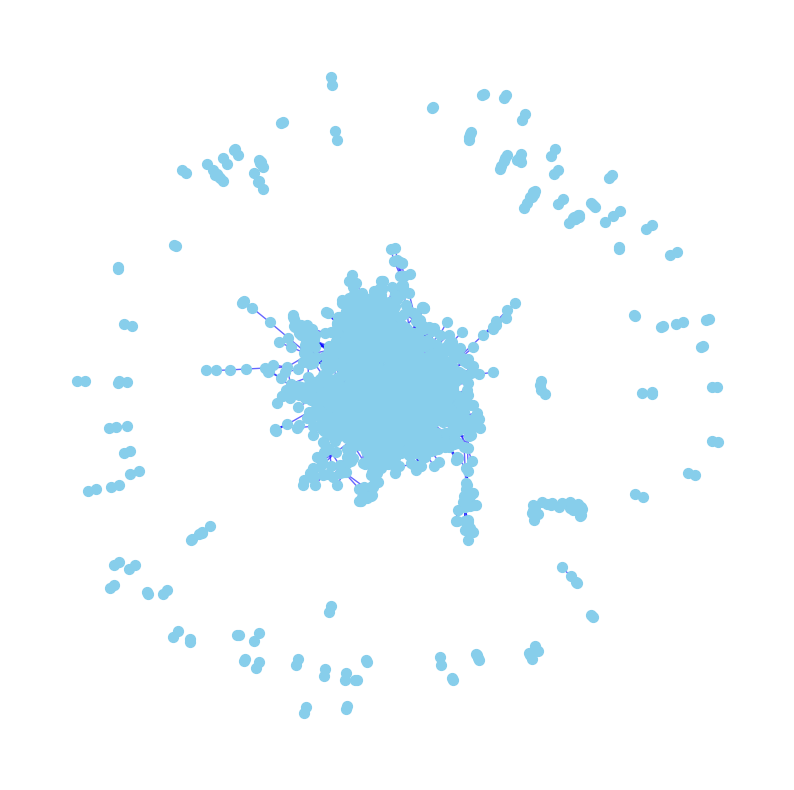

In [17]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Your Graph Data (Assuming 'data' is the graph object you provided)
# Example for data creation:
# data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Plotting the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1, alpha=0.6, edge_color='blue')

# Hide node labels and axis
plt.axis('off')

# Show the plot
plt.show()


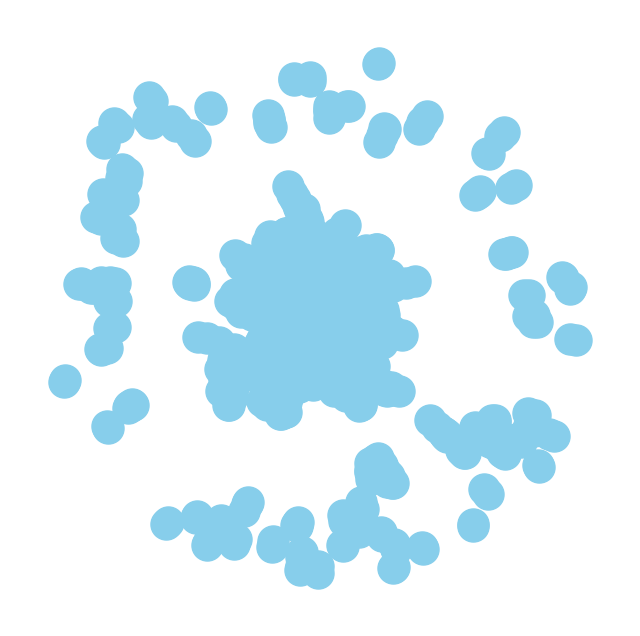

In [ ]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='black')
# nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black')

plt.axis('off')
plt.show()